# POC replicate table 4 of the previous paper by subsetting according to industry characteristics

# Objective(s)

Replicate the second table of the previous paper

![](https://drive.google.com/uc?export=view&id=1dUWzs5Uqm4A23E-i5aPpKYADx10RJevk)

* LDC and DC comes from the world bank classification, and are already in the table
* The list of homogeneous goods is in the S3
* Small/large city is be computed by using:
  *  the number of product exported in 2003. If the count of product is above average, then it can be consider as a large firm
  * The average quantity

# Metadata

* Epic: Epic 2
* US: US 2
* Date Begin: 10/4/2020
* Duration Task: 1
* Description: Replicate table 2 with and without the export share covariates
* Step type:  
* Status: Active
* Source URL: US 02 Table 2 country, good city
* Task type: Jupyter Notebook
* Users: Thomas Pernet
* Watchers: Thomas Pernet
* User Account: https://468786073381.signin.aws.amazon.com/console
* Estimated Log points: 10
* Task tag: #econometrics,#ols
* Toggl Tag: #model-training
* Meetings:  
* Email Information:  
  * thread: Number of threads: 0(Default 0, to avoid display email)
  *  

# Input Cloud Storage [AWS/GCP]

## Table/file

* Origin: 
* Athena
* Name: 
* quality_vat_export_covariate_2003_2010
* Github: 
  * https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_prepare_tables_model/02_transform_table_baseline_covariates.md

# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'thomas_vat_credentials.csv'
region = 'eu-west-3'
bucket = 'chinese-data'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [63]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

- Filename: XX
- Main table S3: https://s3.console.aws.amazon.com/s3/buckets/vat-rebate-quality/DATA/TRANSFORMED/?region=eu-west-3&tab=overview
- Extra table: https://s3.console.aws.amazon.com/s3/buckets/chinese-data/ADDITIONAL_DATA/INDUSTRY_CHARACTERISTICS/?region=eu-west-3
    - Energy: energy.csv
    - high tech: high_tech.csv
    - skill-oriented: test_es.csv
    - RD oriented: test_rd.csv

In [5]:
list(
    map(
        lambda x:
        
    s3.download_file(
        key = 'ADDITIONAL_DATA/INDUSTRY_CHARACTERISTICS/{}'.format(x),
    path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
    ), 
        ['energy.csv','high_tech.csv', 'test_es.csv', 'test_rd.csv']
    )
)

[None, None, None, None]

# Models to estimate

The model to estimate is: 

## Fixed Effect

| Benchmark | Origin            | Name                     | Description                                                                                                                                                                                                                                                                                                                                    | Math_notebook     |
|-----------|-------------------|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------|
| Yes       | Current           | city-product             |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}$     |
| Yes       | Current           | city-product-regime      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}^R$   |
| Yes       | Current           | city-sector-year         | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}$    |
| Yes       | Current           | city-sectorーregime-year | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}^R$  |
| Yes       | Current           | product-destination      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{pj}$     |
| Yes       | Previous baseline | Product-year             | account for all factors that affect product-level export irrespective of the trade regime in a given year                                                                                                                                                                                                                                      | $\alpha_{pt}$     |
| No        | Previous baseline | firm-product-eligibility | captures all the factors that affect firms regardless of the time and type of regime. This firm‒product pair eliminates the demand shocks that firms face and that are not correlated with the types of status. The fixed effects are also responsible for potential correlations between subsidies, R&D, or trade policies and VAT rebates.   | $\alpha^{E}_{it}$ |
| No        | Previous baseline | HS4-year-eligibility     |                                                                                                                                                                                                                                                                                                                                                | $\alpha^{E}_{st}$ |
| No        | Previous baseline | city-year                | captures the differences in demand, capital intensity, or labor supply that prevail between cities each year                                                                                                                                                                                                                                   | $\alpha_{ct}$     |
| No        | Candidate         | destination-year         | Captures additional level of control, encompassing all the shocks and developments in the economies to which China exports.                                                                                                                                                                                                                    | $\alpha_{dt}$     |


- city-product: `fe_ck`
- City-sector-year: `fe_cst`
- City-product-regime: `fe_ckr`
- City-sector-regime-year: `fe_csrt`
- Product-year: `fe_kt`
- Product-destination: `fe_pj`
- Destination-year: `fe_jt`

In [6]:
import function.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [7]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




Load industrial data

In [44]:
path_energy = '../../../00_Data_catalogue/temporary_local_data/energy.csv'
energy <- read_csv(path_energy, col_types = "d") %>% mutate(energy = 'ENERGY')
table(energy$energy)


ENERGY 
  1313 

In [45]:
path_high_tech = '../../../00_Data_catalogue/temporary_local_data/high_tech.csv'
high_tech <- read_csv(path_high_tech, col_types = "d")  %>% mutate(high_tech = 'HIGHTECH')
table(high_tech$high_tech)


HIGHTECH 
      93 

In [47]:
path_es = '../../../00_Data_catalogue/temporary_local_data/test_es.csv'
skilled <- read_csv(path_es, col_types = "dc") %>% 
mutate(skilled = ifelse( hi_s_e1 == 1, 'SKILLED', 'UNSKILLED')) %>%
filter(skilled == 'SKILLED')
table(skilled$skilled)


SKILLED 
    196 

In [51]:
path_rd = '../../../00_Data_catalogue/temporary_local_data/test_rd.csv'
rd <- read_csv(path_rd, col_types = "dd") %>% 
mutate(rd = ifelse( rd_o == 0, 'RD', 'NO_RD')) %>%
filter(rd == 'RD')
table(rd$rd)


RD 
 7 

In [52]:
path = '../../../00_Data_catalogue/temporary_local_data/quality_vat_export_covariate_2003_2010.csv'
df_final <- read_csv(path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(regime = relevel(regime, ref='NOT_ELIGIBLE')) %>%
left_join(energy, by= "hs6") %>%
left_join(high_tech, by= "hs6") %>%
left_join(skilled, by= c("hs4" = "gbt")) %>%
left_join(rd, by= c("hs4" = "gbt"))

Parsed with column specification:
cols(
  .default = col_double(),
  cityen = col_character(),
  regime = col_character(),
  country_en = col_character(),
  iso_alpha = col_character(),
  income_group = col_character(),
  income_group_ldc_dc = col_character(),
  size_quantity = col_character(),
  size_product = col_character()
)

See spec(...) for full column specifications.



## Table 1: Industry characteristics, no covariates

$$
\begin{aligned}
\operatorname{Quality}_{c,k,j, t}^{R} &=\alpha \ln \operatorname{VAT} \operatorname{Export} \operatorname{tax}_{k, t-1} \times \text { Eligibility }^{R} \\
&+F E_{c,k}^{R}+F E_{c,s,t}^{R}+ F E_{k, t}+\epsilon_{ck,j, t}^{R}
\end{aligned}
$$

* Column 1 excludes rare earth products with the main fixed effect:
  * city-product-regime: `fe_ckr`
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 2 excludes energy intensive industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 3 excludes high tech industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 5 excludes High skilled oriented with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt`
  
Sector is defined as the GBT 4 digits

In [59]:
#### RARE HEARTH
t_0 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(hs6 != 850511),
            exactDOF = TRUE)

#### ENERGY
t_1 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter( is.na(energy)),
            exactDOF = TRUE)

#### HIGH TECH
t_2 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(high_tech)),
            exactDOF = TRUE)

#### SKILLED
t_3 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(skilled)),
            exactDOF = TRUE)
##### RD
t_4 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(rd)),
            exactDOF = TRUE)

In [60]:
import os
try:
    os.remove("Tables/table_0.txt")
except:
    pass
try:
    os.remove("Tables/table_0.tex")
except:
    pass
try:
    os.remove("Tables/table_0.pdf")
except:
    pass

In [62]:
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("City-sector-regime-year fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("product-year fixed effects", "Yes", "Yes", "Yes", "Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_0.txt"
)

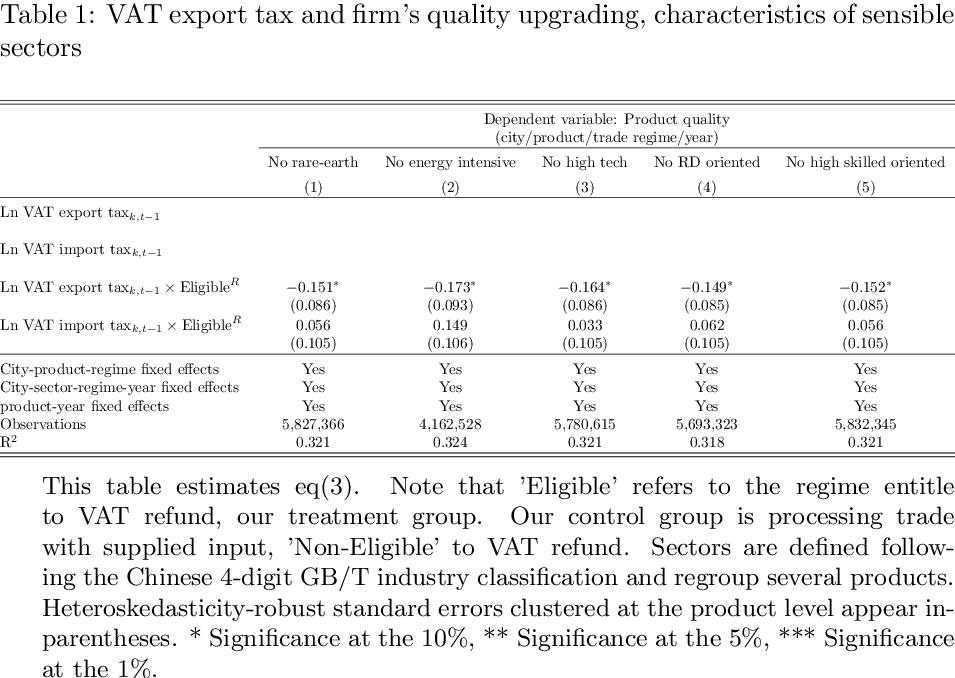

In [64]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'No rare-earth': 1,
    'No energy intensive': 1,
    'No high tech': 1,
    'No RD oriented': 1,
    'No high skilled oriented': 1,
}
multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = 0,
            #multi_lines_dep = None,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

## Table 2: Industry characteristics, with covariates city, regime destination, product

$$
\begin{aligned}
\operatorname{Quality}_{c,k,j, t}^{R} &=\alpha \ln \operatorname{VAT} \operatorname{Export} \operatorname{tax}_{k, t-1} \times \text { Eligibility }^{R} \\
&+F E_{c,k}^{R}+F E_{c,s,t}^{R}+ F E_{k, t}+\epsilon_{ck,j, t}^{R}
\end{aligned}
$$

* Column 1 excludes rare earth products with the main fixed effect:
  * city-product-regime: `fe_ckr`
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 2 excludes energy intensive industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 3 excludes high tech industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 5 excludes High skilled oriented with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt`

Sector is defined as the GBT 4 digits

In [ ]:
#### RARE HEARTH
t_0 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckjr + lag_soe_export_share_ckjr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(hs6 != 850511),
            exactDOF = TRUE)
#### ENERGY
t_1 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckjr + lag_soe_export_share_ckjr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter( is.na(energy)),
            exactDOF = TRUE)

#### HIGH TECH
t_2 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckjr + lag_soe_export_share_ckjr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(high_tech)),
            exactDOF = TRUE)

#### SKILLED 
t_3 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckjr + lag_soe_export_share_ckjr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(skilled)),
            exactDOF = TRUE)
##### RD
t_4 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckjr + lag_soe_export_share_ckjr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(rd)), 
            exactDOF = TRUE)

In [ ]:
import os
try:
    os.remove("Tables/table_1.txt")
except:
    pass
try:
    os.remove("Tables/table_1.tex")
except:
    pass
try:
    os.remove("Tables/table_1.pdf")
except:
    pass

In [ ]:
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("City-sector-regime-year fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("product-year fixed effects", "Yes", "Yes", "Yes", "Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_1.txt"
)

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'LDC': 1,
    'DC': 1,
    'Homogeneous': 1,
    'Heterogeneous': 1,
    'Small HS6': 1,
    'Large HS6': 1,
    'Small Quantity': 1,
    'Large Quantityk': 1,
}
multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = 1,
            #multi_lines_dep = None,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

## Table 3: Industry characteristics, with covariates city, regime, product

$$
\begin{aligned}
\operatorname{Quality}_{c,k,j, t}^{R} &=\alpha \ln \operatorname{VAT} \operatorname{Export} \operatorname{tax}_{k, t-1} \times \text { Eligibility }^{R} \\
&+F E_{c,k}^{R}+F E_{c,s,t}^{R}+ F E_{k, t}+\epsilon_{ck,j, t}^{R}
\end{aligned}
$$


* Column 1 excludes rare earth products with the main fixed effect:
  * city-product-regime: `fe_ckr`
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 2 excludes energy intensive industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 3 excludes high tech industries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt` 
* Column 5 excludes High skilled oriented with the main fixed effect:
  * city-product-regime: `fe_ckr` 
  * city-sector-regime-year: `fe_csrt` 
  * product-year: `fe_kt`

Sector is defined as the GBT 4 digits

In [ ]:
#### RARE HEARTH
t_0 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(hs6 != 850511),
            exactDOF = TRUE)

#### ENERGY
t_1 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter( is.na(energy)),
            exactDOF = TRUE)

#### HIGH TECH
t_2 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(high_tech)),
            exactDOF = TRUE)

#### SKILLED 
t_3 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(skilled)),
            exactDOF = TRUE)
##### RD
t_4 <- felm(kandhelwal_quality ~ln_lag_tax_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(is.na(rd)), 
            exactDOF = TRUE)

In [ ]:
import os
try:
    os.remove("Tables/table_2.txt")
except:
    pass
try:
    os.remove("Tables/table_2.tex")
except:
    pass
try:
    os.remove("Tables/table_2.pdf")
except:
    pass

In [ ]:
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("City-sector-regime-year fixed effects","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("product-year fixed effects", "Yes", "Yes", "Yes", "Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name="Tables/table_2.txt"
)

In [ ]:
tbe1  = """
This table estimates eq(3). 
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'LDC': 1,
    'DC': 1,
    'Homogeneous': 1,
    'Heterogeneous': 1,
    'Small HS6': 1,
    'Large HS6': 1,
    'Small Quantity': 1,
    'Large Quantityk': 1,
}
multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = 2,
            #multi_lines_dep = None,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
def create_report(extension = "html", keep_code = False):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            pass  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True)